# __Codename: Plutus IO__

##### __Functional TODOs__:

1. Change "resources" ==> "cash"
2. Improve visualisations:
  - cash vs. portfolio evolution
  - yearly return on portfolio vs. on each portfolio element
3. Add shares
  - in company
  - stocks
4. Add land
5. Add "tax account"
6. Add mortgage prepayment, fix...
7. Add concept of a family

##### __Technical TODOs__:

1. Isolate configuration file
2. Isolate Market, Instrument, Portfolio, ... setup => Not to be committed to GIT!!

In [17]:
# libs
import sys, logging
sys.path.append("/home/rado/Projects/wealthManagement/plutus/")

from context.instruments import CurrentAccount, Mortgage
from context.assets import RealEstate
from context.agreements import RentalAgreement, UtilitiesAgreement, EmployeeContract
from context.party import Party, Portfolio

# delete log
import os
if os.path.exists("plutus.log"):
  os.remove("plutus.log")

#### [1] Config

In [2]:
config = {}
config['n_years'] = 1
config['logLevel'] = logging.DEBUG
config['logPath'] = 'plutus.log'

In [3]:
# loggers
logger = logging.getLogger('plutusLogger')
logger.setLevel(config['logLevel'])
formatter = logging.Formatter('%(asctime)s :: %(name)s | %(levelname)s | %(message)s')

fileHandler = logging.FileHandler(config['logPath'])
fileHandler.setFormatter(formatter)
logger.addHandler(fileHandler)

# streamHandler = logging.StreamHandler()
# streamHandler.setFormatter(formatter)
# logger.addHandler(streamHandler)

In [4]:
logger.info('============================================')
logger.info('============ CONFIGURATION  ================')
logger.info('============================================')
logger.info('')
logger.info('[1] General: ')
logger.info(' - n_years: '+str(config['n_years']))

logger.info('')
logger.info('[2] Market: ')

#### [2] Market

In [5]:
# inflation_index
logger.info('Adding inflation index.')
inflation_index={}
inflation_rate=0.03
inflation_index[0]=1.0
for step in range(1,config['n_years']*12+1):
    inflation_index[step]=inflation_index[step-1]+inflation_rate/12
    logger.debug('Inflation index step ' + str(step) + ' : ' + str(inflation_index[step]))

logger.info('Adding real-estate index.')

# real-estate market
re_index={}
re_rate=0.07
re_index[0]=1.0
for step in range(1,config['n_years']*12+1):
    re_index[step]=re_index[step-1]+re_rate/12
    logger.debug('Real estate index step ' + str(step) + ' : ' + str(re_index[step]))

#### [3] Events

In [6]:
# instrument-level events
mortgage_flat_events = {'cost': [{'step':4, 'value':10000}, {'step': 5, 'value': 270000}], 'income':{}}
employee_contract_events = {'modify': [{'step':2, 'value':5000}, {'step':4, 'value': -3000}], 'bonus':[{'step':9, 'value':1e5}]}
current_account = {}

# party-level events
rado_events = {'sell': [{'step':6, 'id':'rado_mortgage_flat'}]
             , 'buy': [{'step':8, 'id':'rado_flat3', 'type':'RealEstate', 'current_market_value':3e6, 'property_tax':2000, 'house_community_costs':6000, 'real_estate_index':re_index}]
             , 'transfer': [{'step':10, 'from':'rado_current_account', 'to':'rado_saving_account','amount':1e6}]}

#### [4] Portfolio

In [7]:
logger.info('')
logger.info('[3] Portfolio: ')

In [8]:
# Income
employee_contract = EmployeeContract(id='rado_credo', salary = 135000, income_tax_rate = 0.42, logger=logger, events=employee_contract_events)

# SA & CA
current_account = CurrentAccount(id='rado_current_account', current_outstanding=3e5, monthly_cost= 100, cnit=0.0, logger=logger, primary=True)
saving_account = CurrentAccount(id='rado_saving_account', current_outstanding=0.0, monthly_cost= 0.0, cnit=0.015, logger=logger)

# Real Estate
mortgage = Mortgage(id='rado_mortgage', principal=3e6, cnit=0.02, maturity_in_years=30, logger=logger)
mortgage_flat = RealEstate(id='rado_mortgage_flat', current_market_value=5e6, property_tax = 2000, house_community_costs = 6000, real_estate_index = re_index, logger=logger, events=mortgage_flat_events)

#### [5] Parties

In [9]:
rado = Party(id='Rado'
             , logger=logger 
             , initial_free_resources=10000
             , initial_portfolio=Portfolio(logger, current_account, saving_account, mortgage, mortgage_flat, employee_contract)
             , monthly_expenditures=20000
             , discount_rate=0.015
             , events=rado_events)

## __Simulation__

In [10]:
logger.info('')
logger.info('============================================')
logger.info('============== SIMULATION  =================')
logger.info('============================================')
logger.info('')

In [11]:
rado.live(config['n_years']*12+1)

In [12]:
# plots
from core.plots import PartyPlotter

plt = PartyPlotter(rado)

### Plots

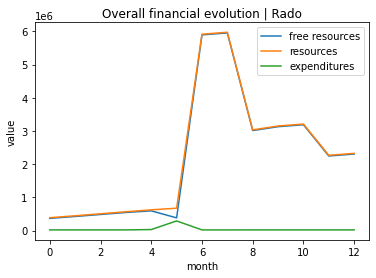

In [13]:
plt.plot_overall_financial_status()

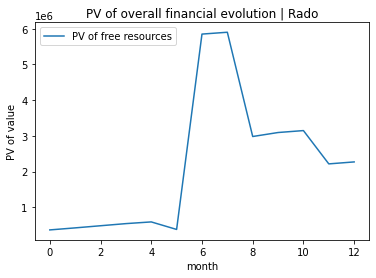

In [14]:
plt.plot_overall_financial_status_pv()

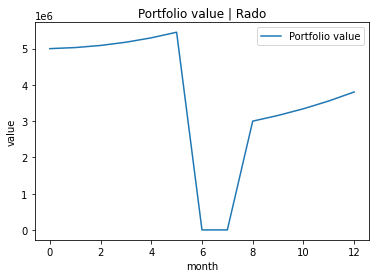

In [15]:
plt.plot_portfolio_value()

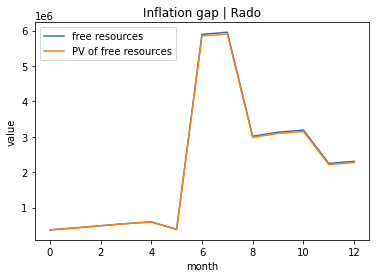

In [16]:
plt.plot_inflation_gap()